# 环境介绍
本示例在微調模型階段是使用google colap L4，之後微調好模型是在本地端windows上進行操作

# 本示例概要
本示例主要是带领大家如何在如何訓練属于自己的大模型，並利用deepseek的GRPO技術來進行微調，模型這裡我使用的是meta-Llama-3.1-8B-Instruct，這樣不會再跟別人搶資源還可以建置屬於自己客製化的LLM，那我们接着来实作吧。

# 安装说明

1️⃣ google colap上的操作


1.   我們查看是否使用GPU





In [ ]:
!nvidia-smi


2.   因為會有軟體版本衝突，請執行時需要考慮當時的google colap的版本，以下都是當下為了版本進行了修改



In [ ]:
!pip uninstall -y torch torchvision torchaudio  # 先卸载 Colab 自带的 torch
!pip install torch --index-url https://download.pytorch.org/whl/cu118  # 安装适用于 Colab 的 torch


In [ ]:
!pip uninstall -y torch torchvision torchaudio


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [ ]:
!pip install unsloth


In [ ]:
!pip install --upgrade pillow

In [ ]:
!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b

In [ ]:
!pip install vllm



3.   防止google colap跳出什麼訊息防止中斷，所以採取先跳過，然後拉去deepseek的GRPO來進行预訓練


In [3]:
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)




4.   開始用訓練模型


In [ ]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)



In [ ]:
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

dataset = load_dataset('json',data_files='/content/dataset/dataset.json')

def formatting_prompts_func(split = "train") -> Dataset:
    data = load_dataset('json',data_files='/content/dataset/dataset.json', split = "train")
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = formatting_prompts_func()

# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]



In [ ]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 6, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    # max_steps and save_steps default 250 ,To save time, I set 25
    max_steps = 25,
    save_steps = 25,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)


trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()




5.   將模型進行轉檔，根據自己本地端的配置來適配，我這邊選擇q4_k_m，微調好把模型下載下來。我們將/content/model下載到我們雲端硬盤來，方面後面進行下載。


In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if True: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )



6.   掛載google driver指令

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




7.   將模型檔複製到google driver



In [16]:
import shutil
# 要複製的檔案路徑
source_file_path = "/content/model/unsloth.Q4_K_M.gguf"

# 目標檔案路徑，這裡是My Drive的根目錄，你可以修改成你想要的路徑
target_file_path = "/content/drive/MyDrive/Colab Notebooks/deepseek_r1/unsloth.Q4_K_M.gguf"

# 複製檔案
shutil.copyfile(source_file_path, target_file_path)

# 確認複製成功
print("檔案已成功複製到Google Drive中的My Drive目錄下。")

檔案已成功複製到Google Drive中的My Drive目錄下。




8.   我們下載到本機上，並跟我附上的Modelfile檔案放在同一個目錄，這個檔案是用於 LLM（大型語言模型）推理配置 的設定檔
9.   然後開啟命令提示字元，執行下面的命令，第一步先切換檔案所在目錄，透過ollama將我們剛剛訓練好的unsloth.Q4_K_M.gguf轉成名叫myR1model。接下來查看myR1model是否有成功放在ollama裡，接下來進行操作模型看效果如何。然後就完成我們微調模型的操作囉。


> cd D:\deepseek-r1\Fine-Tune


> ollama create myR1model -f Modelfile



> ollama list



> ollama run myR1model


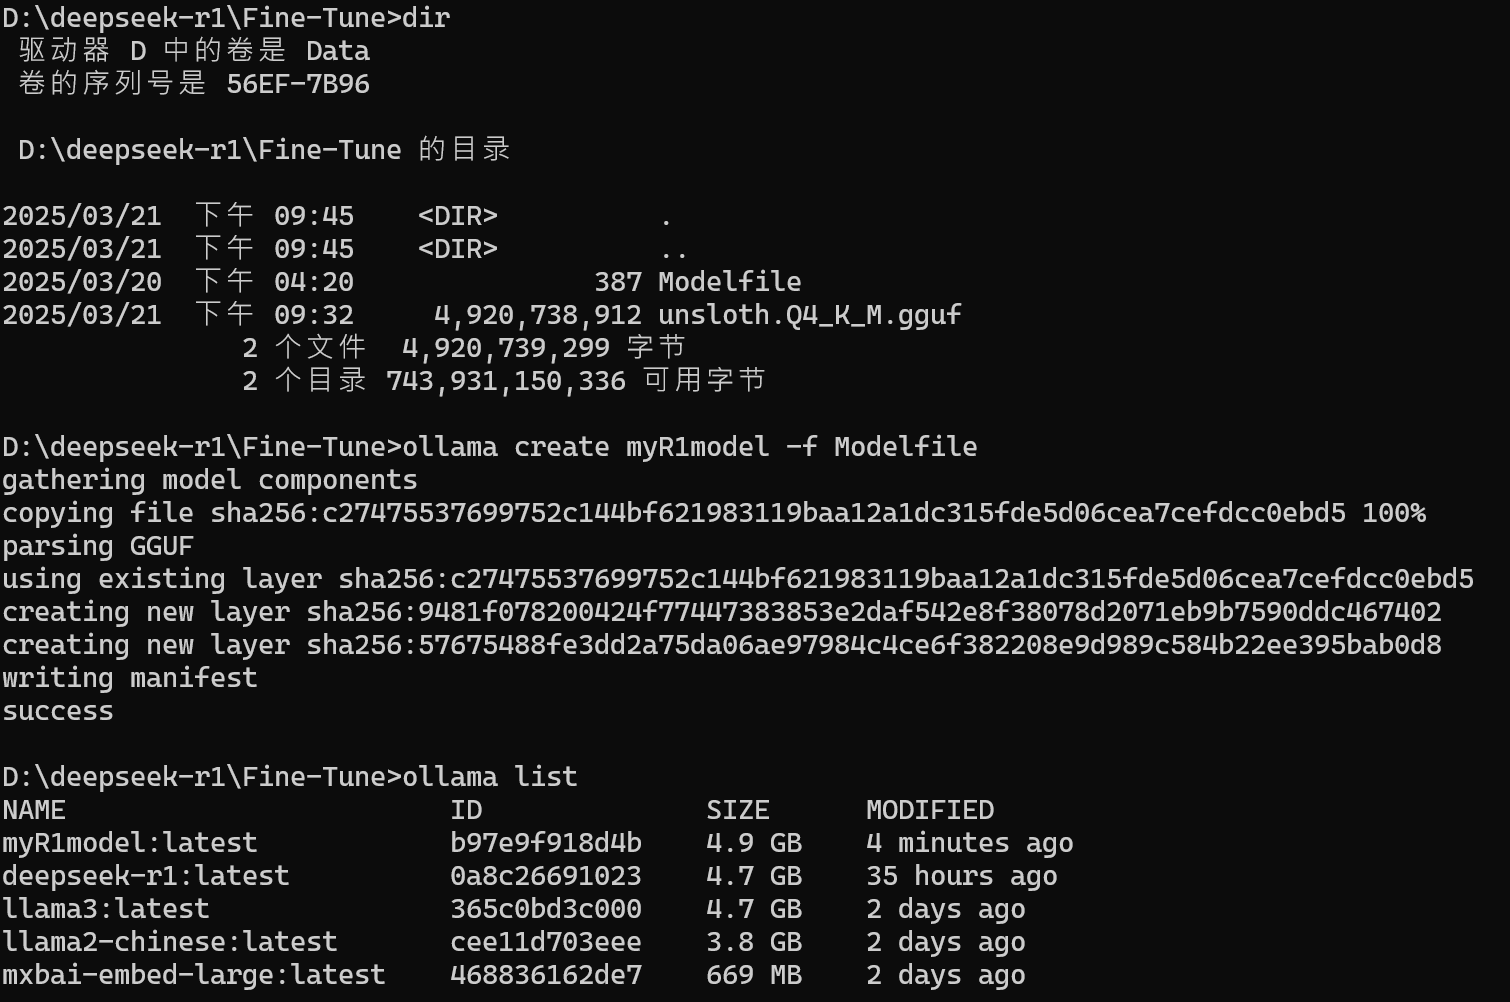





